<a href="https://colab.research.google.com/github/Yagwar/Sociadisticas/blob/master/alc_bog_load_JSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.style.use('seaborn-talk')
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = 'gdrive/My Drive/Freelancer/alc_bog_19/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cuentas=["ClaudiaLopez","carlosfgalan",#"angelamrobledo",
         "MiguelUribeT",#"angelagarzonc","luchogarzon",
         "hollmanmorris"]#,"MAndreaNieto","CelioNievesH","jerojasrodrigue","LuisErnestoGL"]
ids_cands=["137908875","64791701",#"165748292",
           "163341528",#"325856294","60161414",
           "87266285"]#,"999594384","240409671","233001872","2499219806"]

# Loader

In [0]:
#get users and mentions from the download files:
tweets_datas_path = [drive_path+"candidatos_alcaldia_20.json",
                     drive_path+"candidatos_alcaldia_19.json"]
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]
tw_device=[]# print(twits[rnd_ind]["source"])
tw_date=[]# print(twits[rnd_ind]["created_at"])


for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop[0]])
                tw_device.append(tweet["source"])
                tw_date.append(tweet["created_at"])
            except:
                continue

In [0]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n",
      "Tweets con dispositivos registrado  :",len(tw_device),"\n",
      "Tweets con fechas registradas       :",len(tw_date),"\n"
     )

Tweets identificados con código     : 366379 
 Tweets con usuario identificado     : 366379 
 Tweets con nombre de usuario        : 366379 
 Textos de tweets recuperados        : 366379 
 Total de Menciones en los tweets    : 1483673 
 Tweets con menciones identificadas  : 366379 
 Tweets con dispositivos registrado  : 366379 
 Tweets con fechas registradas       : 366379 



In [0]:
tw_device=[dvc[dvc.find(">")+1:dvc.find("<",2)] for dvc in tw_device]
tw_text=np.array(tw_text)

### Tabla de menciones

In [0]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [0]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 16274


In [0]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")
# se utiliza el código para evitar conteos por homónimos

In [0]:
id_ments.head()


col_0,count
row_0,
163341528,170911
87266285,120264
137908875,99057
64791701,53291
49849732,36469


In [0]:
top_n=150


In [0]:
ments_ids_top=list(id_ments.index[:top_n])

In [0]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])
mntns_candts=np.array([[cand in tw_mntns[2] for cand in ids_cands]for tw_mntns in mentioned_ids])

In [0]:
print(mntns_top_ocurr.shape)
print(mntns_candts.shape)

(366379, 150)
(366379, 4)


In [0]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [0]:
# twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=tw_id)
df_mntns_candts=pd.DataFrame(mntns_candts,columns=cuentas, index=tw_id)

In [0]:
print(df_mntns_top_ocurr.shape)
print(df_mntns_candts.shape)

(366379, 150)
(366379, 4)


In [0]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 53473


row_0
Twitter for Android        224329
Twitter for iPhone          82889
Twitter Web App             51217
Twitter for iPad             5434
TweetDeck                     969
Twitter Web Client            929
Mobile Web (M2)               159
Twitter Media Studio          103
TweetCaster for Android        47
Hootsuite Inc.                 46
Name: count, dtype: int64

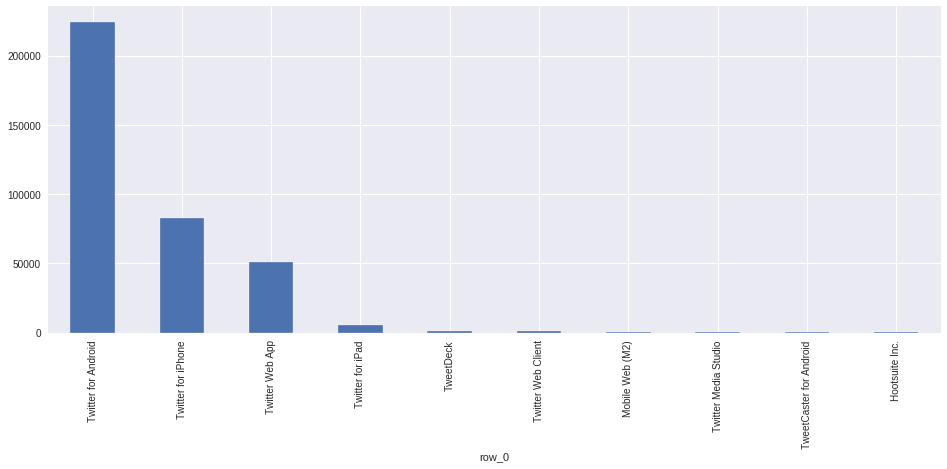

In [0]:
mpl.style.use("seaborn")
devices=pd.crosstab(index=np.array(tw_device), columns="count")
devices=devices.sort_values(by=['count'] , ascending=False)["count"]
devices[:10].plot(figsize=(16, 6), kind="bar")
devices[:10]

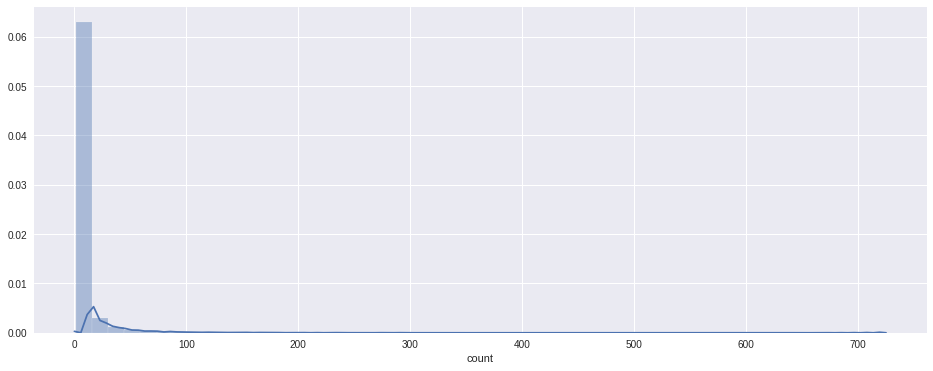

In [0]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [0]:
round(ids_freqs.describe(),3)

count    53473.000
mean         6.852
std         20.228
min          1.000
25%          1.000
50%          2.000
75%          5.000
max        724.000
Name: count, dtype: float64

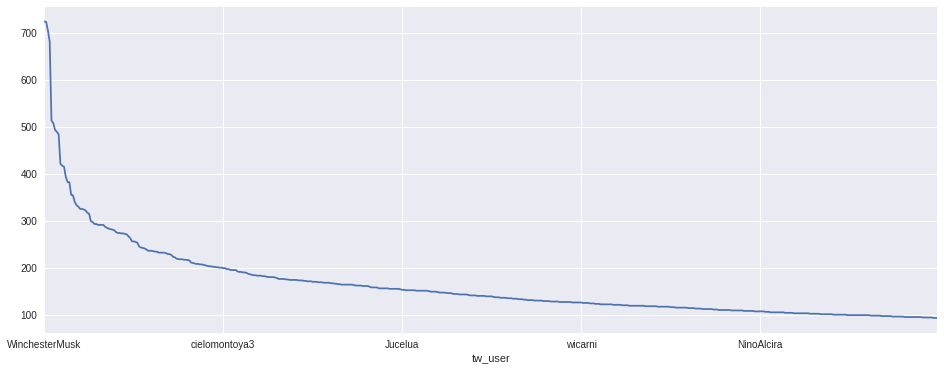

In [0]:
ids_freqs[:500].plot(figsize=(16, 6))

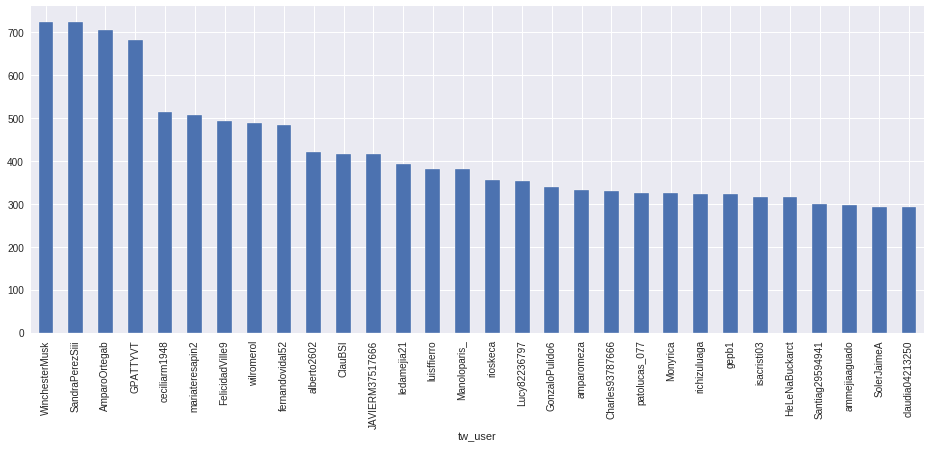

In [0]:
ids_freqs[:30].plot(figsize=(16, 6), kind="bar")
plt.savefig(drive_path+'top_tweeters.png')

In [0]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
WinchesterMusk     724
SandraPerezSiii    723
AmparoOrtegab      705
GPATTYVT           681
ceciliarm1948      513
mariateresapin2    508
FelicidadVille9    493
wilromerol         489
fernandovidal52    484
alberto2602        421
ClauBSI            417
JAVIERM37517666    415
ledamejia21        393
luisffierro        382
Manoloparis_       382
rioskeca           355
Lucy82236797       354
GonzaloPulido6     340
amparomeza         333
Charles93787666    330
patolucas_077      325
Monyrica           325
richizuluaga       324
gepb1              322
isacristi03        317
HeLeNaBuckarct     315
Santiag29594941    299
ammejiaaguado      297
SolerJaimeA        293
claudia04213250    293
jhor73             291
Napoleo00594410    291
GLORIDMQ           291
rpinzon12          291
Monajaneth         287
maxmaye15354547    285
WARSS01            283
dragonnegro2395    282
jonathan_sole      281
Neal48734709       280
HefzibaInes        276
SIGNOMAGICTENIS    274
ricardorosania     274
mar

In [0]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

16268

MiguelUribeT       170911
HOLLMANMORRIS      120264
ClaudiaLopez        99057
CarlosFGalan        53291
petrogustavo        36469
GustavoBolivar      13106
WRadioColombia       9990
CeDemocratico        8054
AlvaroUribeVel       7968
ghitis               7655
angelamrobledo       6757
EnriquePenalosa      6577
jcpastrana           6511
ELTIEMPO             5420
IvanCepedaCast       4794
AndresCamiloHR       4746
NoticiasCaracol      4665
CantorWerner         4434
MilesHMora2          4371
jbagbam74            4310
dtype: int64


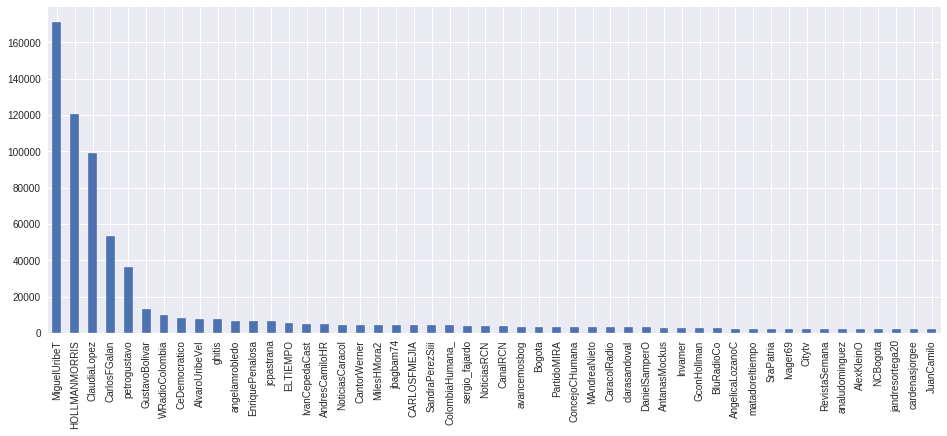

In [0]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'top_mentions.png')

MiguelUribeT     170911
hollmanmorris    120264
ClaudiaLopez      99057
carlosfgalan      53291
dtype: int64


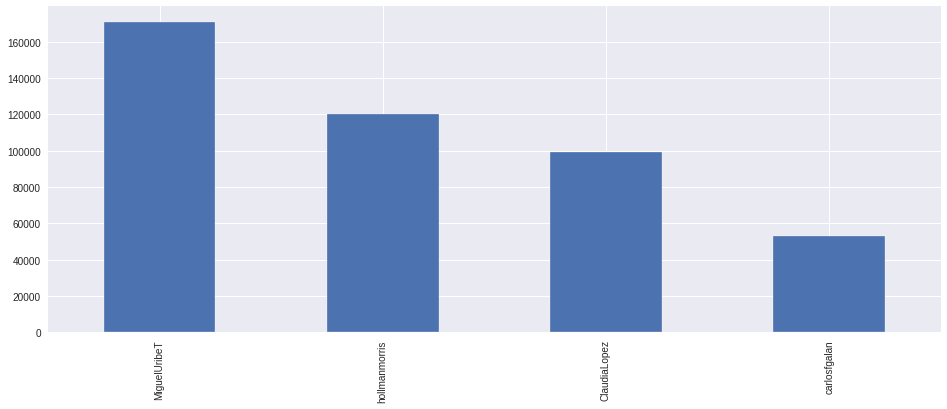

In [0]:
plt.figure(figsize=(16,6))
print (df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'df_mntns_candts.png')

# Relaciones de cuentas

In [0]:
directed_graph_df=df_mntns_top_ocurr.groupby(tw_user).aggregate(sum)
mat_dendr=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr.sample(20)

In [0]:
ments_ward= hierarchy.linkage(mat_dendr.transpose(), 'ward')

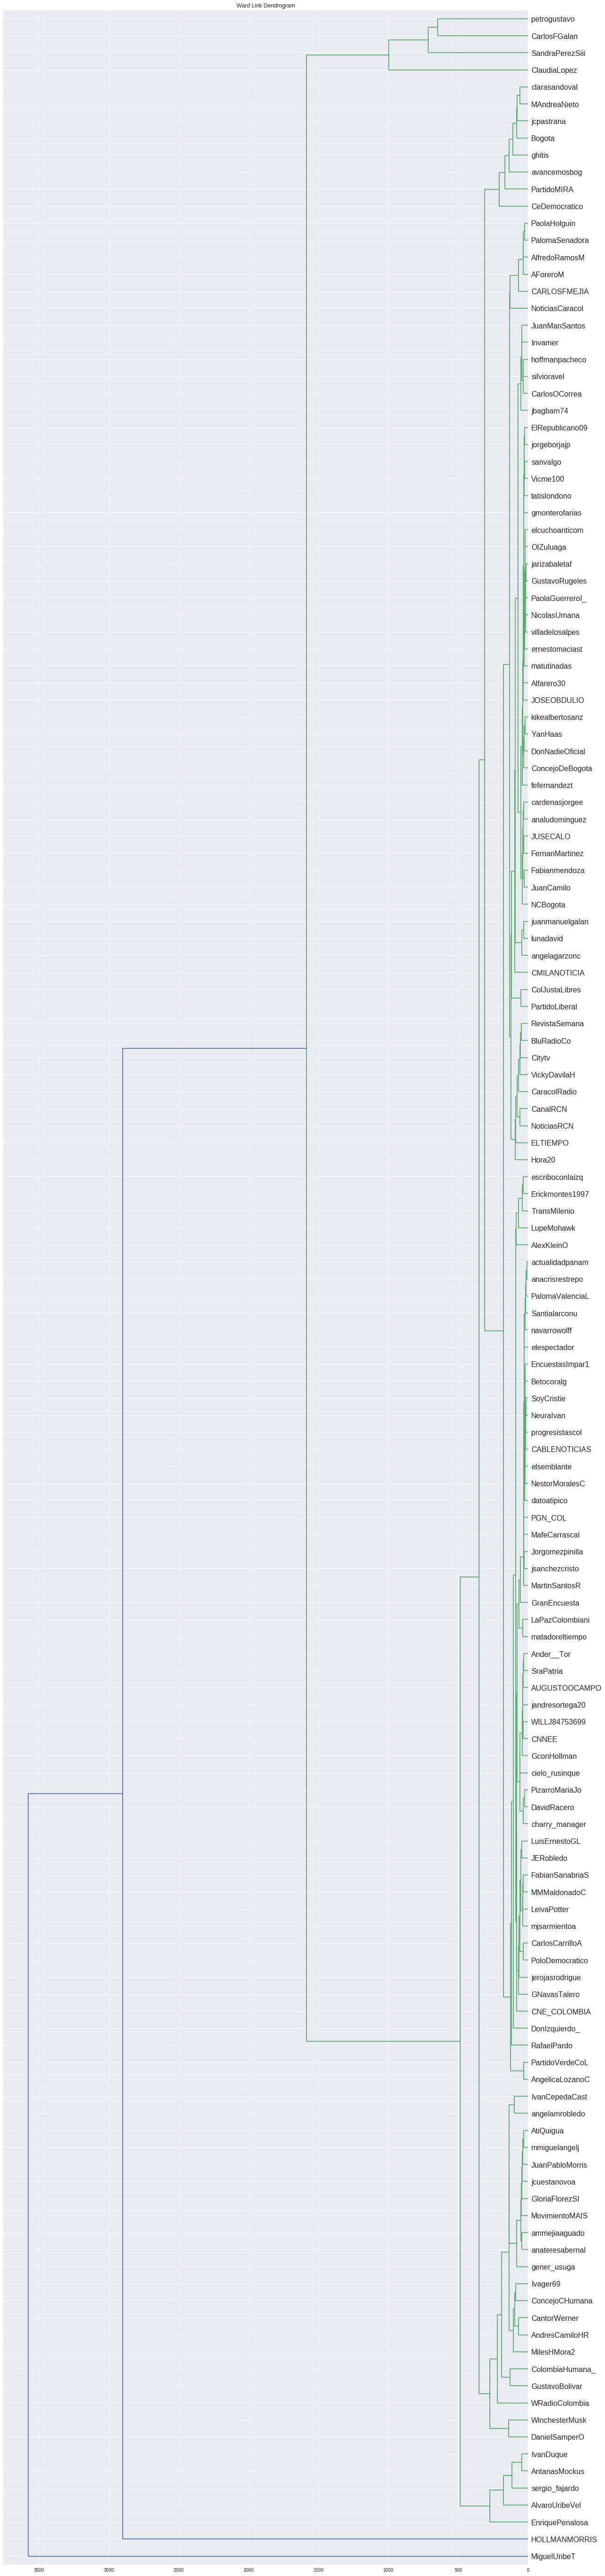

In [0]:
plt.figure(figsize=(20,100))
dn = hierarchy.dendrogram(ments_ward,orientation="left", labels=df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False).index)
plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'ments_dendrograma_ward.png')
plt.show()

In [0]:
directed_graph_df_candts=df_mntns_candts.groupby(tw_user).aggregate(sum)
mat_dendr_candts=directed_graph_df_candts.loc[directed_graph_df_candts.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr_candts.sample(20)

In [0]:
cands_ward= hierarchy.linkage(mat_dendr_candts.transpose(), 'ward')

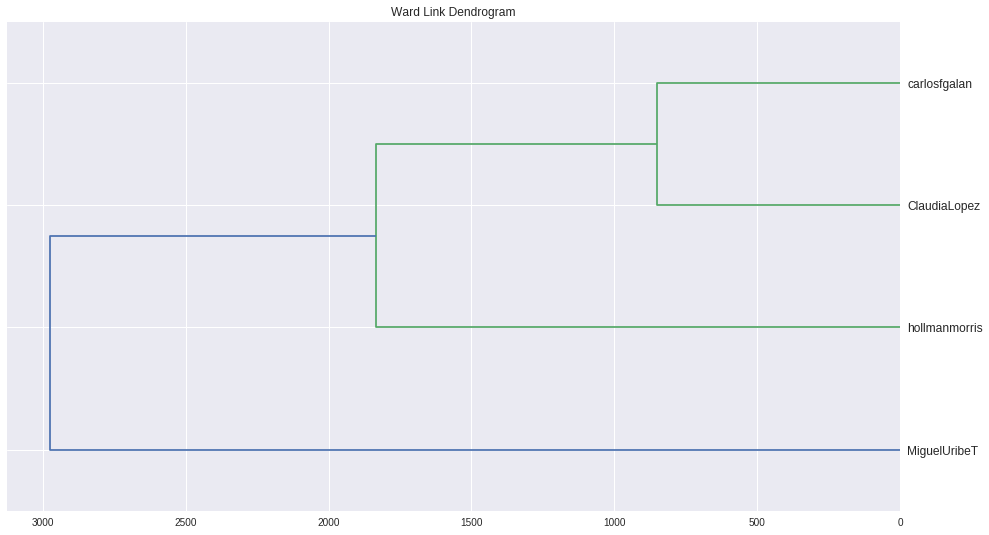

In [0]:
plt.figure(figsize=(16,9))
dn = hierarchy.dendrogram(cands_ward,orientation="left", labels=cuentas)
# plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'cands_dendrograma_ward.png')
plt.show()

# Temporalidad

In [0]:
tw_fechas_df=pd.DataFrame(np.column_stack([tw_user,tw_date]))
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [0]:
time_sample="3600s"#'1440T'#"1800S"#"900S"#"3600s"#

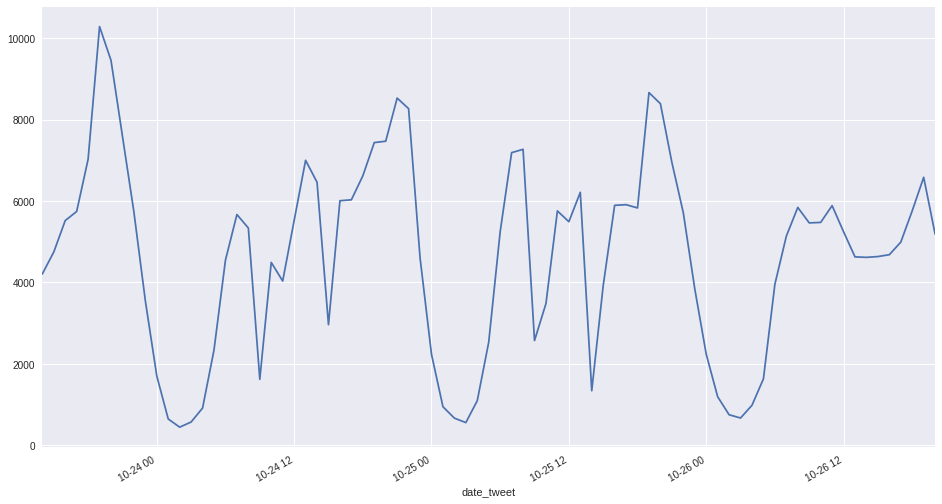

In [0]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

## Menciones

In [0]:
mayor_tweeters=list(directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:10])

In [0]:
tw_fechas_df_top=tw_fechas_df[tw_fechas_df.user.isin(mayor_tweeters)]

In [0]:
twits_filt=pd.crosstab(index=tw_fechas_df_top.index,
                  columns=tw_fechas_df_top["user"])
twits_filt=twits_filt.resample(time_sample).sum()

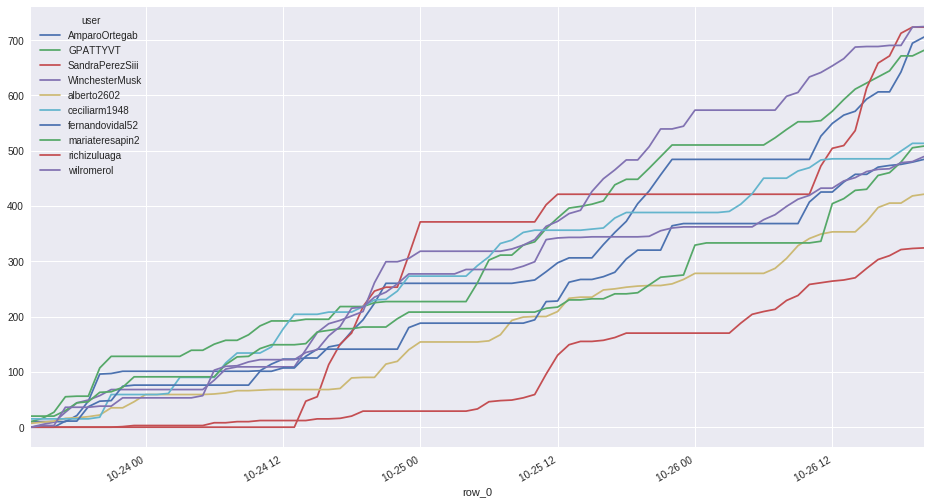

In [0]:
twits_filt.cumsum().plot(figsize=(16,9))

In [0]:
top_ments_df=df_mntns_top_ocurr.copy()*1
top_ments_df.index=tw_fechas_df.index
# top_ments_df.head(20)

In [0]:
top_ments_df_day=top_ments_df.iloc[:,:10].resample(time_sample).sum()

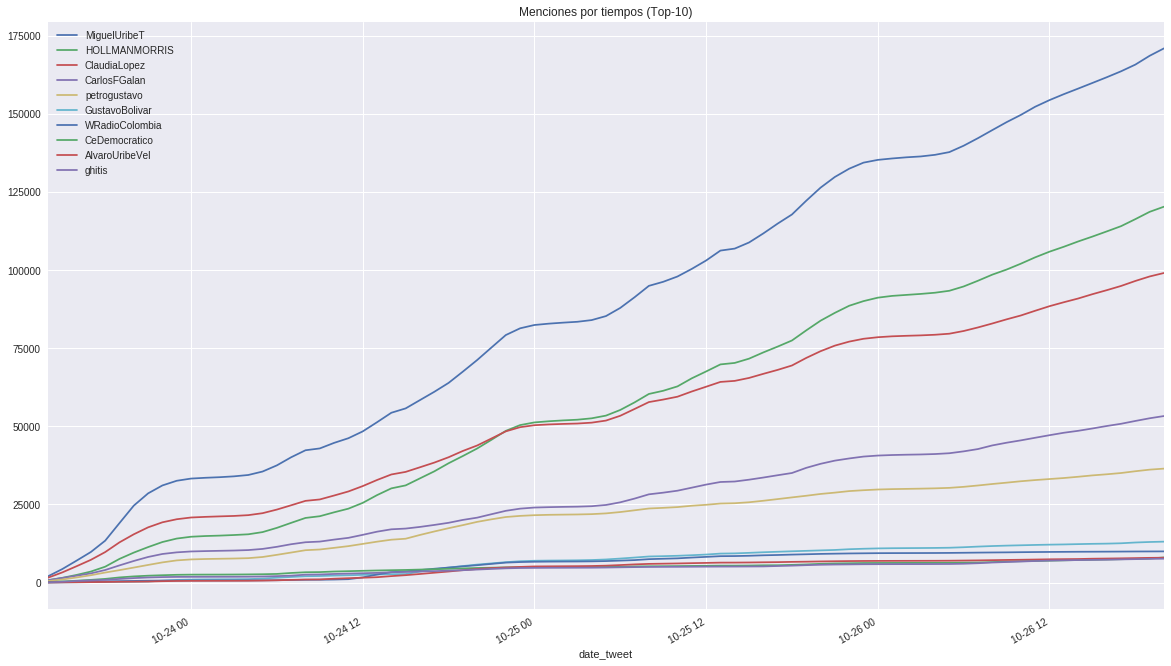

In [0]:
top_ments_df_day.cumsum().plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

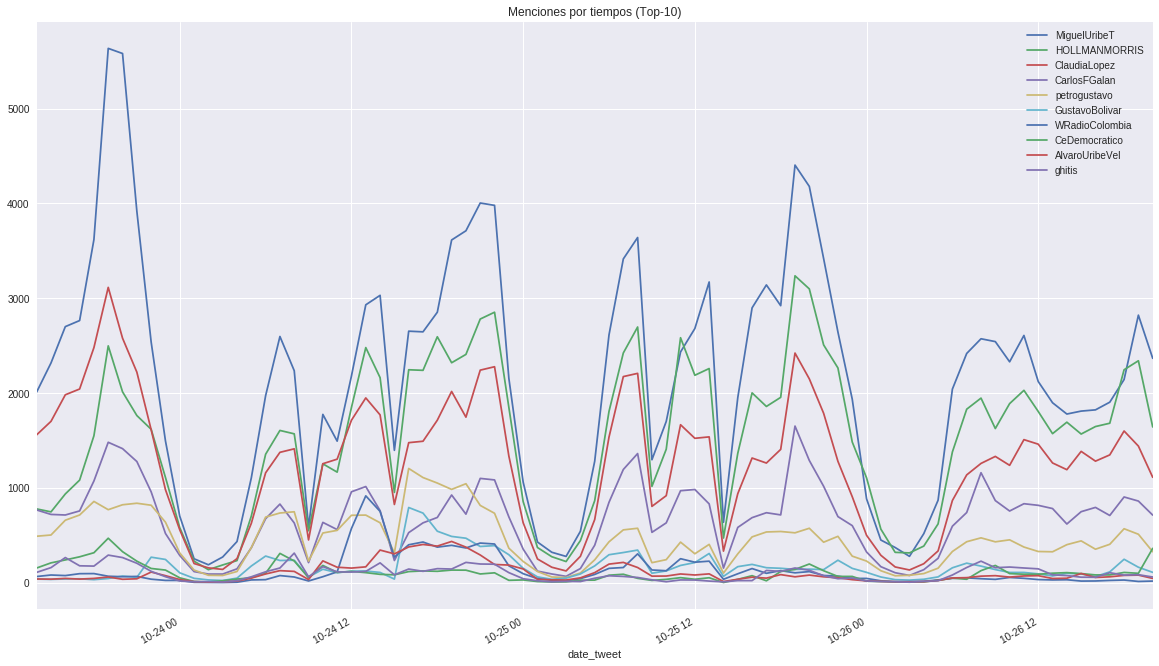

In [0]:
top_ments_df_day.plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

## Candidatos

In [0]:
tw_fechas_df_cands=tw_fechas_df[tw_fechas_df.user.isin(cuentas)]

In [0]:
twits_filt_cands=pd.crosstab(index=tw_fechas_df_cands.index,
                  columns=tw_fechas_df_cands["user"])
twits_filt_cands=twits_filt_cands.resample(time_sample).sum()

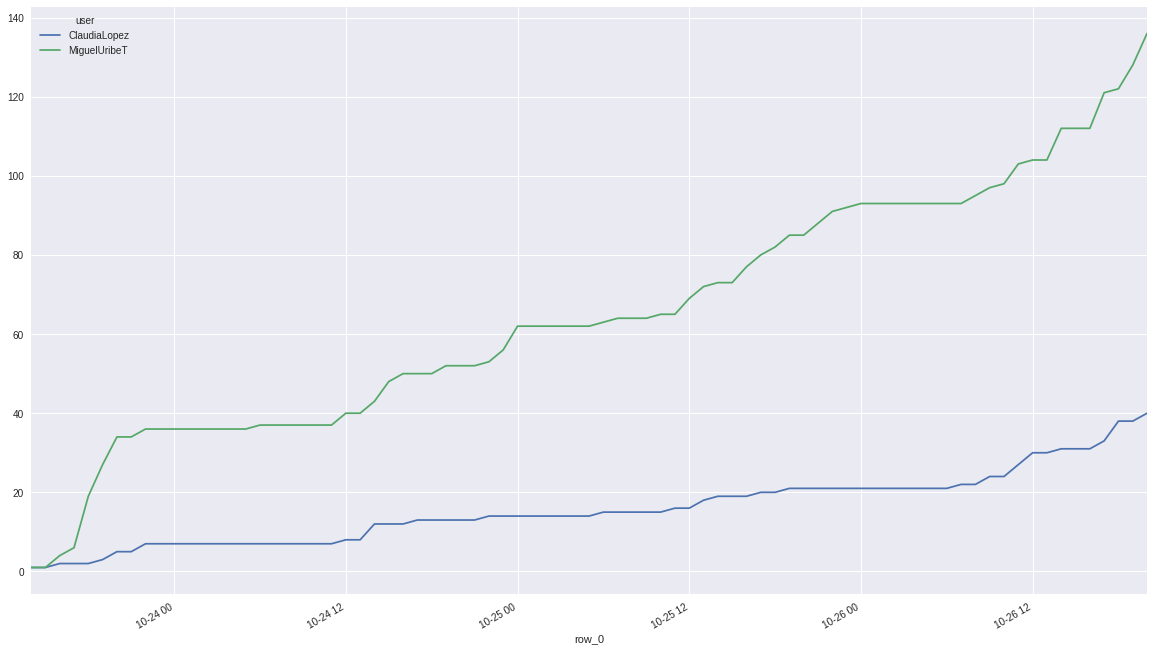

In [0]:
twits_filt_cands.cumsum().plot(figsize=(20,12))# No cuadra este gráfico # Revisar!!!!!!

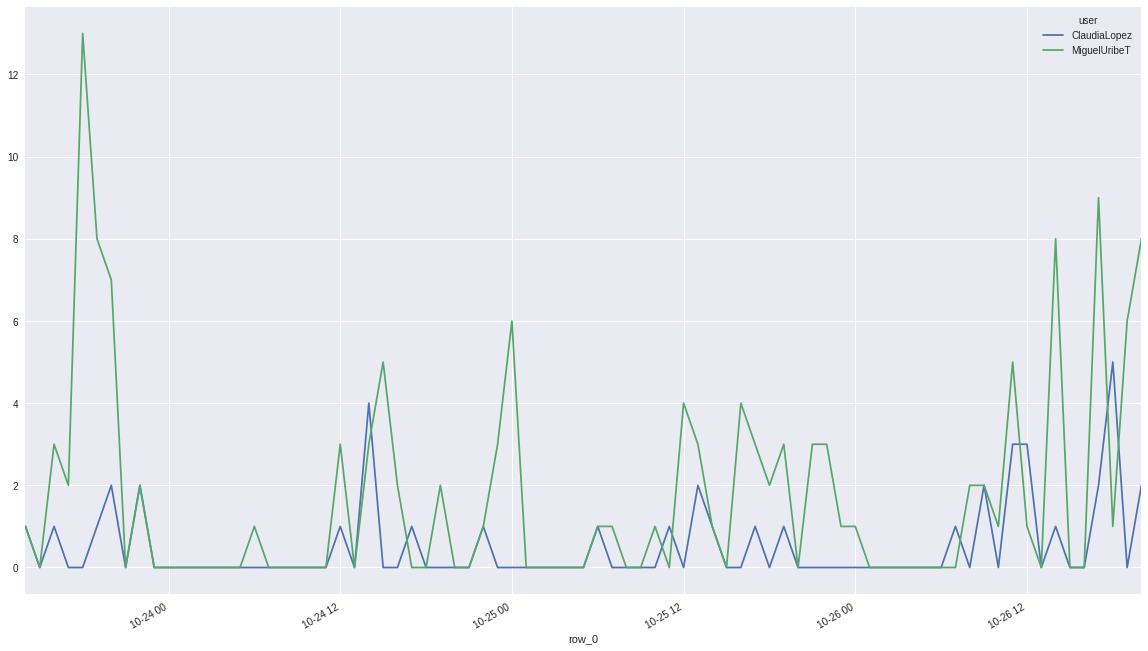

In [0]:
twits_filt_cands.plot(figsize=(20,12))# No cuadra este gráfico # Revisar!!!!!!

# Grafos

In [0]:
mat_size=40
graph_mat=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:mat_size],
                                directed_graph_df.sum(axis=0).sort_values(ascending=False).index[:mat_size]
                               ]
graph_mat.head()

,MiguelUribeT,HOLLMANMORRIS,ClaudiaLopez,CarlosFGalan,petrogustavo,GustavoBolivar,WRadioColombia,CeDemocratico,AlvaroUribeVel,ghitis,angelamrobledo,EnriquePenalosa,jcpastrana,ELTIEMPO,IvanCepedaCast,AndresCamiloHR,NoticiasCaracol,CantorWerner,MilesHMora2,jbagbam74,CARLOSFMEJIA,SandraPerezSiii,ColombiaHumana_,sergio_fajardo,NoticiasRCN,CanalRCN,avancemosbog,Bogota,PartidoMIRA,ConcejoCHumana,MAndreaNieto,CaracolRadio,clarasandoval,DanielSamperO,AntanasMockus,Invamer,GconHollman,BluRadioCo,AngelicaLozanoC,matadoreltiempo
SandraPerezSiii,272.0,215.0,445.0,188.0,28.0,6.0,21.0,1.0,212.0,0.0,13.0,247.0,0.0,8.0,0.0,7.0,0.0,5.0,10.0,0.0,0.0,528.0,2.0,138.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,44.0,74.0,0.0,5.0,1.0,0.0,1.0
WinchesterMusk,212.0,433.0,155.0,99.0,55.0,21.0,35.0,25.0,17.0,2.0,7.0,21.0,0.0,17.0,1.0,6.0,2.0,9.0,9.0,0.0,0.0,3.0,11.0,11.0,1.0,9.0,0.0,4.0,0.0,7.0,7.0,7.0,3.0,39.0,2.0,0.0,3.0,1.0,2.0,3.0
fernandovidal52,37.0,446.0,82.0,36.0,106.0,45.0,18.0,1.0,1.0,0.0,5.0,7.0,0.0,3.0,2.0,24.0,6.0,15.0,10.0,0.0,0.0,4.0,52.0,3.0,5.0,3.0,0.0,2.0,1.0,34.0,0.0,10.0,0.0,2.0,0.0,2.0,4.0,3.0,1.0,3.0
GPATTYVT,604.0,26.0,54.0,69.0,7.0,1.0,25.0,37.0,12.0,5.0,0.0,3.0,11.0,15.0,1.0,0.0,9.0,0.0,0.0,3.0,9.0,0.0,1.0,0.0,22.0,3.0,37.0,16.0,18.0,0.0,9.0,6.0,10.0,0.0,1.0,9.0,0.0,8.0,1.0,0.0
wilromerol,55.0,341.0,135.0,53.0,96.0,41.0,16.0,4.0,14.0,0.0,6.0,23.0,0.0,1.0,5.0,13.0,2.0,27.0,17.0,0.0,0.0,29.0,23.0,11.0,2.0,2.0,0.0,0.0,1.0,23.0,0.0,4.0,0.0,18.0,6.0,1.0,16.0,6.0,1.0,3.0


In [0]:
graph_mat.shape

(40, 40)

In [0]:
graph_df=graph_mat.melt()
graph_df.columns=["tw_para", "freq"]
graph_df["tw_de"]=[usr for i in range(int(len(graph_df)/len(graph_mat.index)))for usr in list(graph_mat.index)]
graph_df=graph_df.loc[:,["tw_de","tw_para","freq"]]

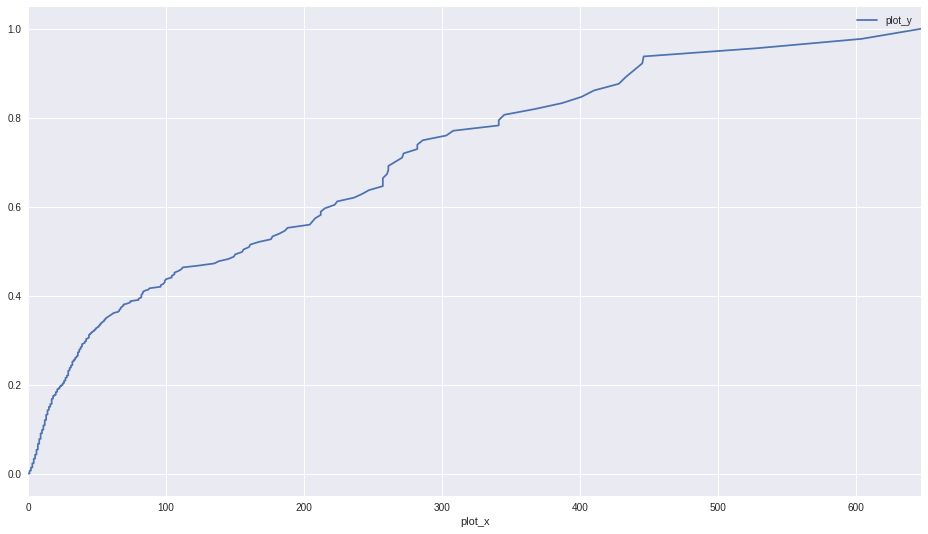

In [0]:
plot_x=np.array(list(graph_df.freq.sort_values(ascending=True)))
plot_y=np.cumsum(plot_x)/sum(plot_x)
cum_freq=pd.DataFrame({"plot_x":plot_x,
                       "plot_y":plot_y})
cum_freq.plot(x="plot_x",
              y="plot_y",
             figsize=(16,9))

In [0]:
min_crit_tw=cum_freq[cum_freq.plot_y>=.3].iloc[0,0]
graph_df_filt=graph_df.loc[graph_df.freq>=min_crit_tw,:]
mx_fr=max(graph_df_filt.freq)
print(min_crit_tw)
print(len(graph_df_filt))
graph_df_filt.sort_values("freq",ascending=False)#.head(20)

42.0
127


,tw_de,tw_para,freq
5,AmparoOrtegab,MiguelUribeT,647.0
3,GPATTYVT,MiguelUribeT,604.0
840,SandraPerezSiii,SandraPerezSiii,528.0
42,fernandovidal52,HOLLMANMORRIS,446.0
80,SandraPerezSiii,ClaudiaLopez,445.0
...,...,...,...
15,maxmaye15354547,MiguelUribeT,43.0
215,maxmaye15354547,GustavoBolivar,42.0
166,mariateresapin2,petrogustavo,42.0
23,Santiag29594941,MiguelUribeT,42.0


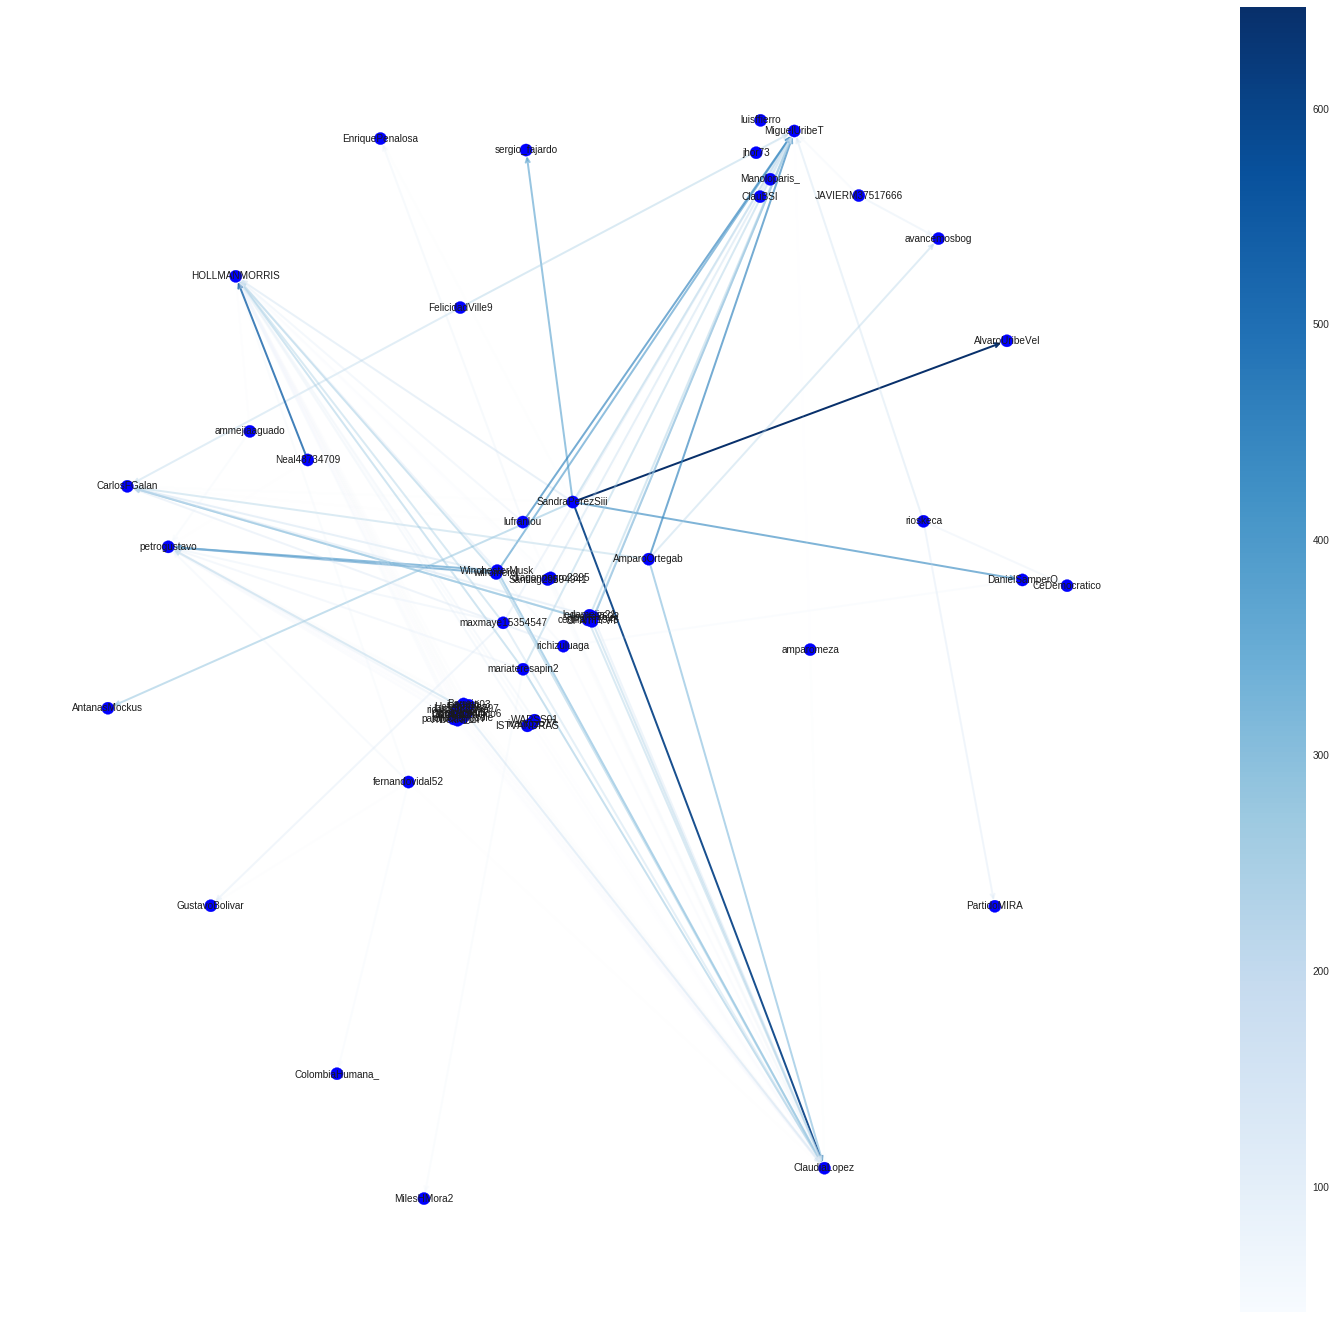

In [0]:
plt.figure(figsize=(26,24))
G= nx.DiGraph()#nx.generators.directed.random_k_out_graph(10, 3, 0.5)
for i, elrow in graph_df_filt.iterrows():
    G.add_edge(elrow[0], elrow[1])

pos = nx.layout.spring_layout(G)

node_sizes = [150 for i in range(len(G))]
M = G.number_of_edges()
edge_colors =[fr for fr in graph_df_filt.freq]#range(2, M + 2)
edge_alphas =[fr/mx_fr for fr in graph_df_filt.freq]#[fr/mx_fr for fr in graph_df_filt.freq]#[(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

nx.draw_networkx_labels(G, pos, font_size=10)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [0]:
g = nx.Graph()


In [0]:
for i, elrow in graph_df_filt.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [0]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 127
# of nodes: 56


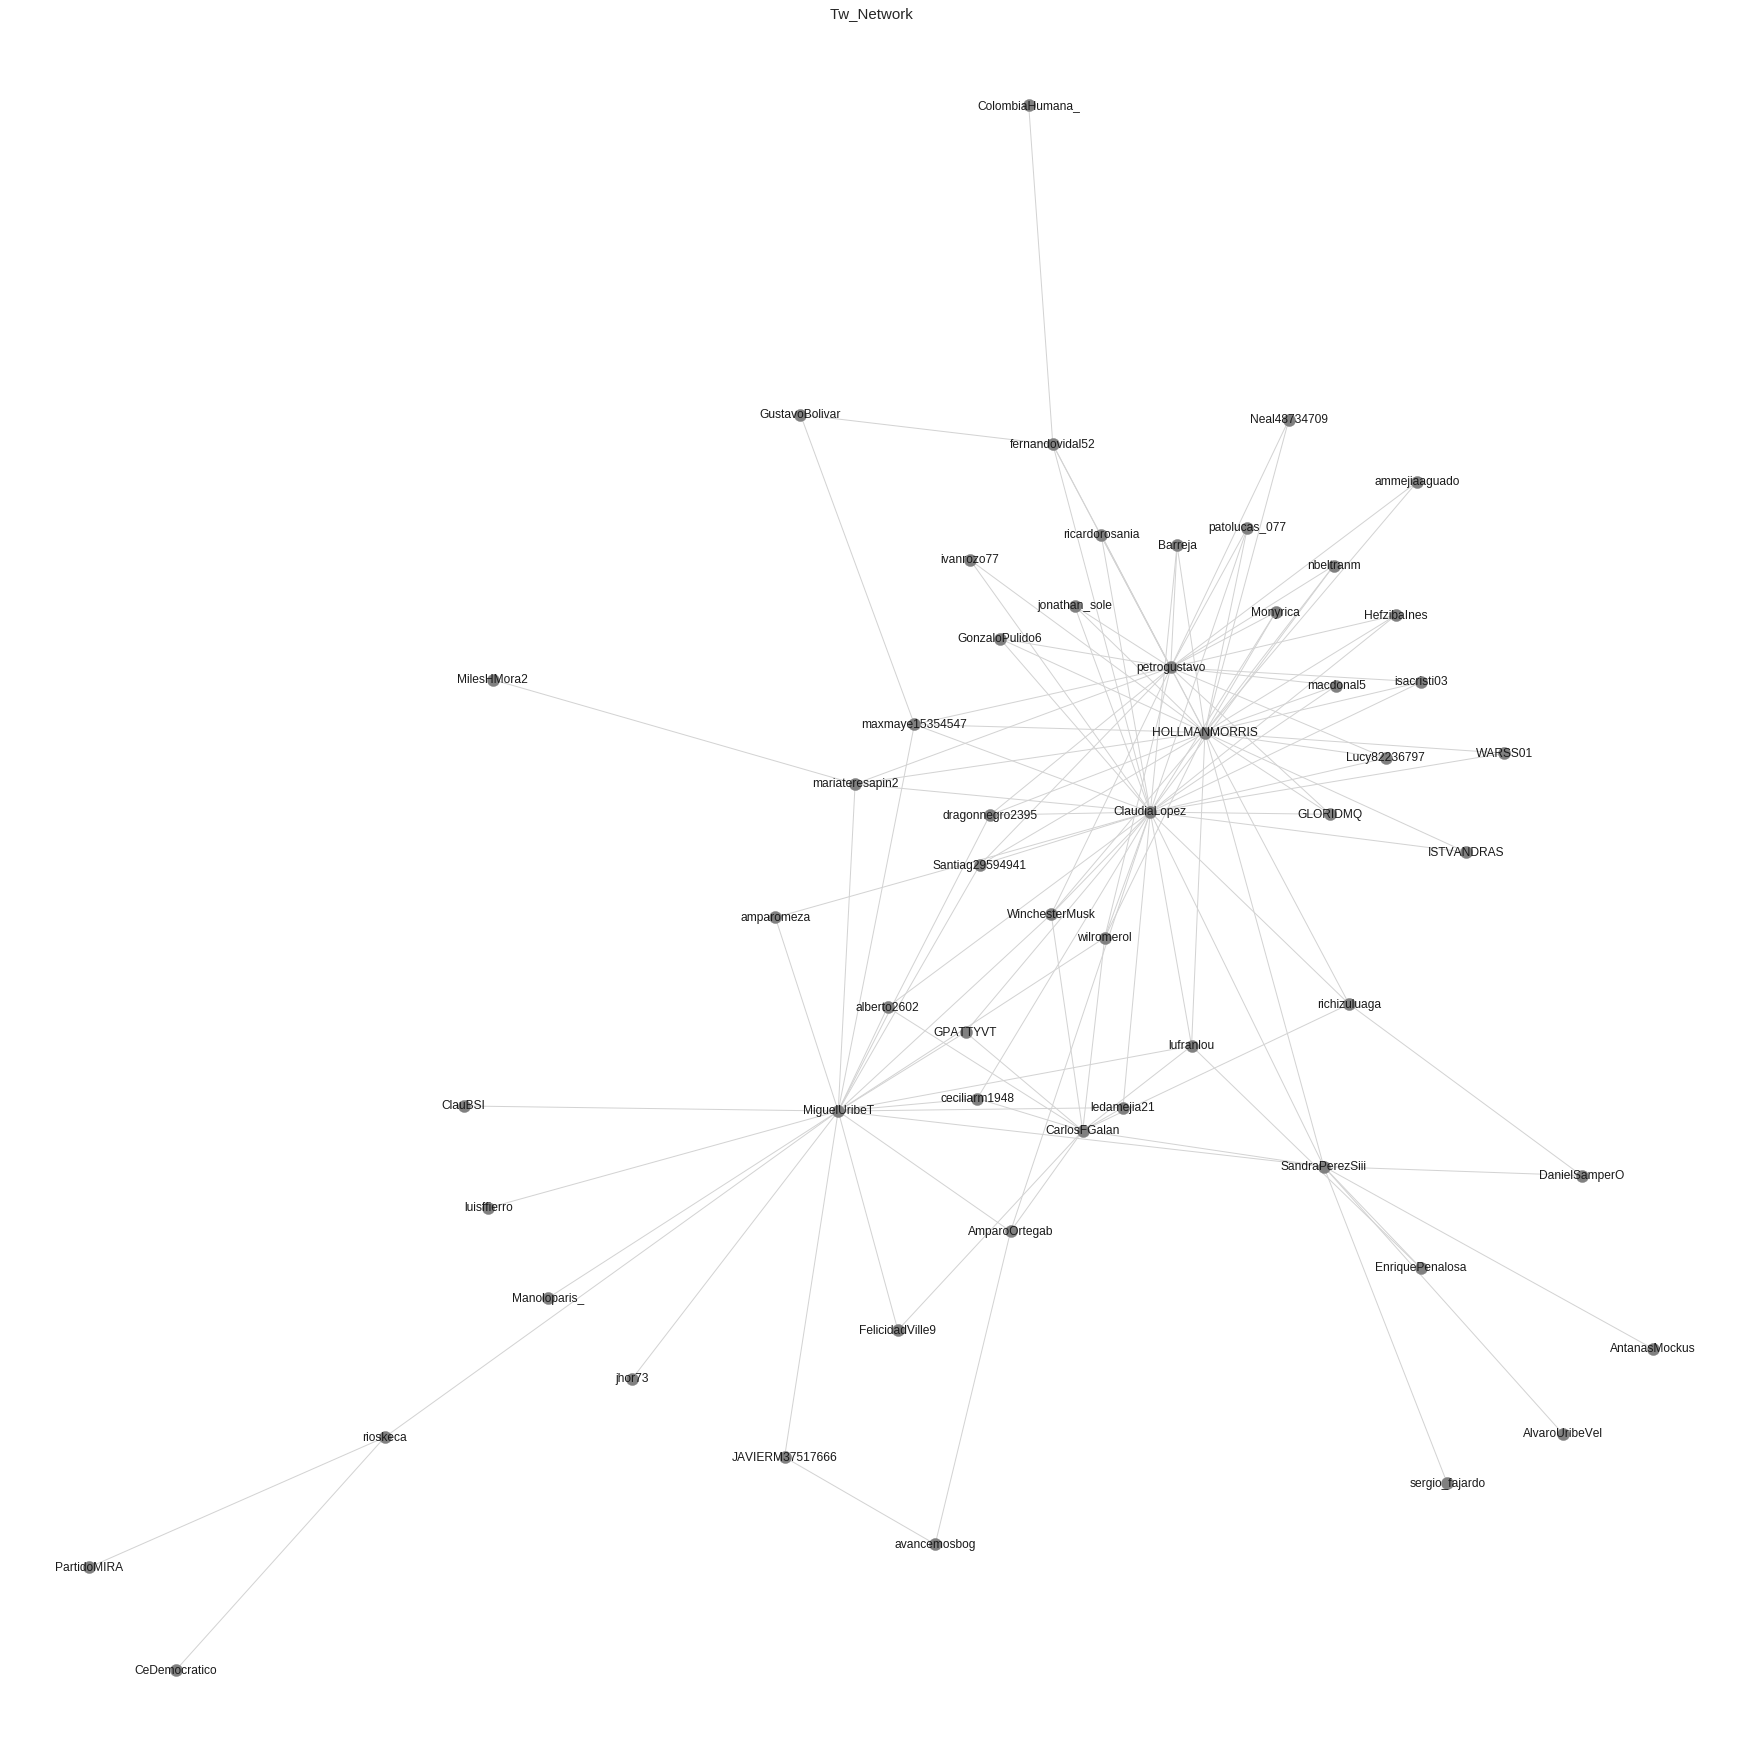

In [0]:
plt.figure(figsize=(24, 24))
nx.draw(g,
        node_size=150,
        edge_color='lightgray',
        node_color='gray',
        with_labels=True)
plt.title('Tw_Network', size=15)
plt.show()
# plt.savefig('tweets_net.png')